In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

2025-11-10 03:52:54.025688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762746774.048728     381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762746774.055485     381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
data_dir = "isic-2020-jpg-256x256-resized"
csv_path = os.path.join(data_dir, "train-metadata.csv")
df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (33126, 4)


,Unnamed: 0,isic_id,patient_id,target
0,0,ISIC_2637011,IP_7279968,0
1,1,ISIC_0015719,IP_3075186,0
2,2,ISIC_0052212,IP_2842074,0
3,3,ISIC_0068279,IP_6890425,0
4,4,ISIC_0074268,IP_8723313,0


In [3]:
df["image_path"] = df["isic_id"].apply(
    lambda x: os.path.join(data_dir, "train-image", "image", f"{x}.jpg")
)
print("Sample image path:", df["image_path"].iloc[0])

Sample image path: /kaggle/input/isic-2020-jpg-256x256-resized/train-image/image/ISIC_2637011.jpg


In [4]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["target"], random_state=42)
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print(train_df["target"].value_counts(normalize=True))

Training samples: 26500
Validation samples: 6626
target
0    0.982377
1    0.017623
Name: proportion, dtype: float64


In [5]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_df['target_str'] = train_df['target'].astype(str)
val_df['target_str'] = val_df['target'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="target_str",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="target_str",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 26500 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.


In [6]:
class_weights_raw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["target"]),
    y=train_df["target"]
)


scale_factor = 0.5
class_weights = {
    0: 1.0,
    1: min(class_weights_raw[1] * scale_factor, 10.0)
}
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 10.0}


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762746848.038047     381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762746848.038781     381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,001 (56.61 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
EPOCHS = 10

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,
        restore_best_weights=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762746853.696577     434 service.cc:148] XLA service 0x793454003980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762746853.696615     434 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762746853.696621     434 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762746854.268110     434 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/829 ━━━━━━━━━━━━━━━━━━━━ 1:10 85ms/step - accuracy: 0.2891 - auc: 0.0000e+00 - loss: 2.2102 - precision: 0.0000e+00 - recall: 0.0000e+00  

I0000 00:00:1762746860.721941     434 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


829/829 ━━━━━━━━━━━━━━━━━━━━ 556s 659ms/step - accuracy: 0.8824 - auc: 0.6463 - loss: 2.5076 - precision: 0.0352 - recall: 0.2047 - val_accuracy: 0.9588 - val_auc: 0.7223 - val_loss: 0.3197 - val_precision: 0.0063 - val_recall: 0.0085 - learning_rate: 1.0000e-04
Epoch 2/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 432s 521ms/step - accuracy: 0.9672 - auc: 0.7493 - loss: 0.5653 - precision: 0.0589 - recall: 0.0584 - val_accuracy: 0.9627 - val_auc: 0.7735 - val_loss: 0.2327 - val_precision: 0.0149 - val_recall: 0.0171 - learning_rate: 1.0000e-04
Epoch 3/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 409s 493ms/step - accuracy: 0.9651 - auc: 0.7128 - loss: 0.8098 - precision: 0.0447 - recall: 0.0431 - val_accuracy: 0.9775 - val_auc: 0.6524 - val_loss: 0.2727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
829/829 ━━━━━━━━━━━━━━━━━━━━ 430s 519ms/step - accuracy: 0.9789 - auc: 0.7603 - loss: 0.5503 - precision: 0.0323 - recall: 0.0070 - val_accuracy: 0.9823 - val_auc: 0.8144

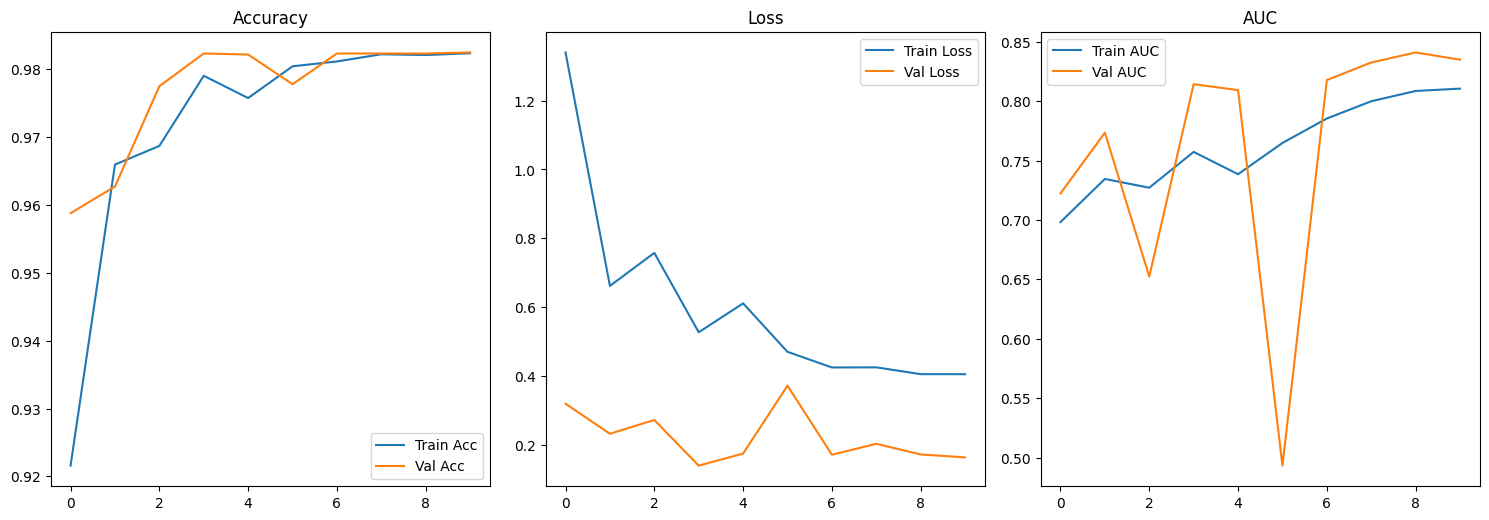

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(2,3,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(2,3,3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend(); plt.title('AUC')

plt.tight_layout()
plt.show()

In [12]:
results = model.evaluate(val_gen)
print(f"\nValidation Results:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]*100:.2f}%")
print(f"AUC: {results[2]:.4f}")

208/208 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9816 - auc: 0.8177 - loss: 0.1809 - precision: 0.0000e+00 - recall: 0.0000e+00

Validation Results:
Loss: 0.1727
Accuracy: 98.23%
AUC: 0.8410


In [11]:
model.save("skin_cancer_cnn_model.h5")
print("Model saved successfully!")

Model saved successfully!
